# **TIME SERIES FORECASTING USING DEEP LEARNING**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [ ]:
data=pd.read_csv(r"E:\Time Series Data.csv")
data["date"] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index("date",inplace=True)
data.dropna(inplace=True)
data.rename(columns={"quantity": "value"},inplace=True)
data

,value
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


<AxesSubplot: xlabel='date'>

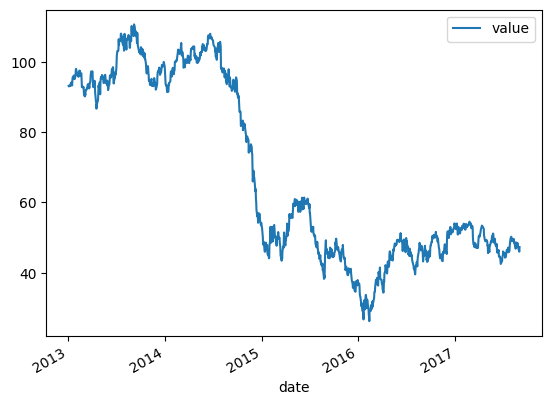

In [ ]:
data.plot()

In [ ]:
look_back_period = 5
data_shifted = data.shift(-1)

In [ ]:
lags = [data_shifted.shift(i) for i in range(1, look_back_period+1)]
lags

[            value
 date             
 2013-01-02    NaN
 2013-01-03  92.97
 2013-01-04  93.12
 2013-01-07  93.20
 2013-01-08  93.21
 ...           ...
 2017-08-25  47.65
 2017-08-28  46.40
 2017-08-29  46.46
 2017-08-30  45.96
 2017-08-31  47.26
 
 [1175 rows x 1 columns],
             value
 date             
 2013-01-02    NaN
 2013-01-03    NaN
 2013-01-04  92.97
 2013-01-07  93.12
 2013-01-08  93.20
 ...           ...
 2017-08-25  47.24
 2017-08-28  47.65
 2017-08-29  46.40
 2017-08-30  46.46
 2017-08-31  45.96
 
 [1175 rows x 1 columns],
             value
 date             
 2013-01-02    NaN
 2013-01-03    NaN
 2013-01-04    NaN
 2013-01-07  92.97
 2013-01-08  93.12
 ...           ...
 2017-08-25  48.45
 2017-08-28  47.24
 2017-08-29  47.65
 2017-08-30  46.40
 2017-08-31  46.46
 
 [1175 rows x 1 columns],
             value
 date             
 2013-01-02    NaN
 2013-01-03    NaN
 2013-01-04    NaN
 2013-01-07    NaN
 2013-01-08  92.97
 ...           ...
 2017-08-25  47.65
 201

In [ ]:
X = pd.concat(lags, axis=1)
X = X.dropna()
X

,value,value,value,value,value
date,,,,,
2013-01-09,93.08,93.21,93.20,93.12,92.97
2013-01-10,93.81,93.08,93.21,93.20,93.12
2013-01-11,93.60,93.81,93.08,93.21,93.20
2013-01-14,94.27,93.60,93.81,93.08,93.21
2013-01-15,93.26,94.27,93.60,93.81,93.08
...,...,...,...,...,...
2017-08-25,47.65,47.24,48.45,47.65,47.39
2017-08-28,46.40,47.65,47.24,48.45,47.65
2017-08-29,46.46,46.40,47.65,47.24,48.45


In [ ]:
Y = data.loc[X.index]

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[1]))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

(number of samples, window size, number of features)

In [ ]:
X_train.shape

(936, 5)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout

def create_model(units, dropout_rate, regularization):
    model = Sequential()
    model.add(Dense(units, input_dim=X.shape[1], activation="relu", kernel_regularizer=regularization))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    # print(model)
    return model

Ref: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers<br>
*L1 regularization penalty is computed as: loss = l1 * reduce_sum(abs(x))*

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

param_grid = {'units': [8, 16, 32], 'dropout_rate': [0.1, 0.2, 0.3], 'regularization': [None, tf.keras.regularizers.l1(0.01), tf.keras.regularizers.l2(0.01)]}
model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=4, verbose=2)
tsscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tsscv, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train, Y_train)

C:\Users\Home\AppData\Local\Temp\ipykernel_488\164438380.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=4, verbose=2)


Epoch 1/100
39/39 - 1s - loss: 0.1500 - 538ms/epoch - 14ms/step
Epoch 2/100
39/39 - 0s - loss: 0.0632 - 123ms/epoch - 3ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0312 - 140ms/epoch - 4ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0450 - 143ms/epoch - 4ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0422 - 152ms/epoch - 4ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0494 - 115ms/epoch - 3ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0356 - 108ms/epoch - 3ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0393 - 82ms/epoch - 2ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0435 - 83ms/epoch - 2ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0260 - 72ms/epoch - 2ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0338 - 66ms/epoch - 2ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0415 - 60ms/epoch - 2ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0319 - 76ms/epoch - 2ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0271 - 69ms/epoch - 2ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0295 - 68ms/epoch - 2ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0513 - 68ms/epoch - 2m

In [ ]:
print(f"Best Hyperparameters: {grid_result.best_params_}")

Best Hyperparameters: {'dropout_rate': 0.1, 'regularization': <keras.regularizers.L2 object at 0x0000021188B2F190>, 'units': 8}


Best Hyperparameters: {'dropout_rate': 0.1, 'regularization': <keras.regularizers.L2 object at 0x0000021188B2F190>, 'units': 8}

In [ ]:
best_model = create_model(units=grid_result.best_params_['units'], dropout_rate=grid_result.best_params_['dropout_rate'], regularization=grid_result.best_params_['regularization'])
history = best_model.fit(X_train, Y_train, epochs=100, batch_size=5, verbose=2)
y_pred = best_model.predict(X_test)

Epoch 1/100
188/188 - 1s - loss: 0.1914 - 697ms/epoch - 4ms/step
Epoch 2/100
188/188 - 0s - loss: 0.1280 - 221ms/epoch - 1ms/step
Epoch 3/100
188/188 - 0s - loss: 0.1202 - 210ms/epoch - 1ms/step
Epoch 4/100
188/188 - 0s - loss: 0.1052 - 221ms/epoch - 1ms/step
Epoch 5/100
188/188 - 0s - loss: 0.0977 - 226ms/epoch - 1ms/step
Epoch 6/100
188/188 - 0s - loss: 0.0839 - 236ms/epoch - 1ms/step
Epoch 7/100
188/188 - 0s - loss: 0.0919 - 242ms/epoch - 1ms/step
Epoch 8/100
188/188 - 0s - loss: 0.0821 - 249ms/epoch - 1ms/step
Epoch 9/100
188/188 - 0s - loss: 0.0804 - 284ms/epoch - 2ms/step
Epoch 10/100
188/188 - 0s - loss: 0.0731 - 298ms/epoch - 2ms/step
Epoch 11/100
188/188 - 0s - loss: 0.0726 - 330ms/epoch - 2ms/step
Epoch 12/100
188/188 - 0s - loss: 0.0728 - 308ms/epoch - 2ms/step
Epoch 13/100
188/188 - 0s - loss: 0.0593 - 289ms/epoch - 2ms/step
Epoch 14/100
188/188 - 0s - loss: 0.0712 - 357ms/epoch - 2ms/step
Epoch 15/100
188/188 - 0s - loss: 0.0616 - 428ms/epoch - 2ms/step
Epoch 16/100
188/18

In [ ]:
y_test_orig = scaler.inverse_transform(Y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

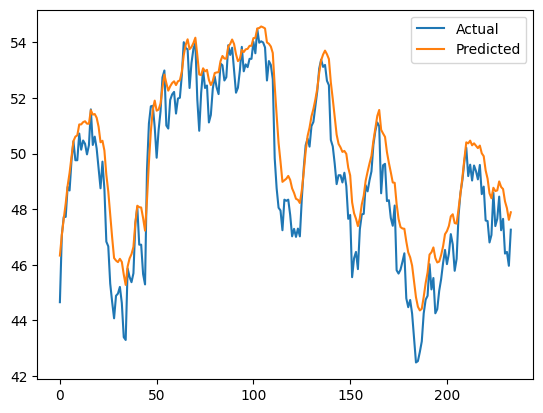

In [ ]:
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred_orig, label='Predicted')
plt.legend()
plt.show()

# Long Short-Term Memory (LSTM) Networks

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [ ]:
data

,value
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [ ]:
look_back_period = 5
data_shifted = data.shift(-1)

In [ ]:
lags = [data_shifted.shift(i) for i in range(1, look_back_period+1)]
lags

[            value
 date             
 2013-01-02    NaN
 2013-01-03  92.97
 2013-01-04  93.12
 2013-01-07  93.20
 2013-01-08  93.21
 ...           ...
 2017-08-25  47.65
 2017-08-28  46.40
 2017-08-29  46.46
 2017-08-30  45.96
 2017-08-31  47.26
 
 [1175 rows x 1 columns],
             value
 date             
 2013-01-02    NaN
 2013-01-03    NaN
 2013-01-04  92.97
 2013-01-07  93.12
 2013-01-08  93.20
 ...           ...
 2017-08-25  47.24
 2017-08-28  47.65
 2017-08-29  46.40
 2017-08-30  46.46
 2017-08-31  45.96
 
 [1175 rows x 1 columns],
             value
 date             
 2013-01-02    NaN
 2013-01-03    NaN
 2013-01-04    NaN
 2013-01-07  92.97
 2013-01-08  93.12
 ...           ...
 2017-08-25  48.45
 2017-08-28  47.24
 2017-08-29  47.65
 2017-08-30  46.40
 2017-08-31  46.46
 
 [1175 rows x 1 columns],
             value
 date             
 2013-01-02    NaN
 2013-01-03    NaN
 2013-01-04    NaN
 2013-01-07    NaN
 2013-01-08  92.97
 ...           ...
 2017-08-25  47.65
 201

In [ ]:
X = pd.concat(lags, axis=1)
X = X.dropna()
X

,value,value,value,value,value
date,,,,,
2013-01-09,93.08,93.21,93.20,93.12,92.97
2013-01-10,93.81,93.08,93.21,93.20,93.12
2013-01-11,93.60,93.81,93.08,93.21,93.20
2013-01-14,94.27,93.60,93.81,93.08,93.21
2013-01-15,93.26,94.27,93.60,93.81,93.08
...,...,...,...,...,...
2017-08-25,47.65,47.24,48.45,47.65,47.39
2017-08-28,46.40,47.65,47.24,48.45,47.65
2017-08-29,46.46,46.40,47.65,47.24,48.45


In [ ]:
Y = data.loc[X.index]

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[1]))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
X_train.shape, Y_train.shape,X_test.shape,Y_test.shape

((936, 5), (936, 1), (234, 5), (234, 1))

Train Shape --> (number of samples, window size, number of features)

In [ ]:
def get_model(params, input_shape):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(1))

	model.compile(loss=params["loss"],
              	optimizer=params["optimizer"],
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
	
	return model

In [ ]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 90,
	"epochs": 100,
	"batch_size": 32,
	"es_patience" : 10
}

model = get_model(params=params, input_shape=X_train.shape[1])

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min',
patience=params["es_patience"])

In [ ]:
model.fit(
	X_train,
	Y_train,
	validation_data=(X_test, Y_test),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=1,
	callbacks=es_callback
)

Epoch 1/100
30/30 [==============================] - 12s 138ms/step - loss: 0.4205 - root_mean_squared_error: 0.6484 - mean_absolute_error: 0.5277 - val_loss: 0.0985 - val_root_mean_squared_error: 0.3138 - val_mean_absolute_error: 0.3131
Epoch 2/100
30/30 [==============================] - 1s 31ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551 - mean_absolute_error: 0.1180 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664 - val_mean_absolute_error: 0.0624
Epoch 3/100
30/30 [==============================] - 1s 27ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - mean_absolute_error: 0.0844 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.0478
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0103 - root_mean_squared_error: 0.1017 - mean_absolute_error: 0.0788 - val_loss: 8.2403e-04 - val_root_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.0237
Epoch 5/100
30/30 [==============================]

In [ ]:
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 2s 11ms/step


array([[-0.86215985],
       [-0.8277938 ],
       [-0.7939382 ],
       [-0.7736314 ],
       [-0.74507314],
       [-0.7317283 ],
       [-0.7072453 ],
       [-0.6810348 ],
       [-0.67795575],
       [-0.6783063 ],
       [-0.66305465],
       [-0.6638074 ],
       [-0.6590496 ],
       [-0.65839297],
       [-0.6651704 ],
       [-0.66394454],
       [-0.64018697],
       [-0.64718914],
       [-0.64755076],
       [-0.6558516 ],
       [-0.67409295],
       [-0.6972624 ],
       [-0.69389987],
       [-0.7071548 ],
       [-0.74739945],
       [-0.77518904],
       [-0.81366843],
       [-0.84653085],
       [-0.87376344],
       [-0.8741198 ],
       [-0.87033474],
       [-0.86257344],
       [-0.8676179 ],
       [-0.892508  ],
       [-0.91024584],
       [-0.87652266],
       [-0.8581409 ],
       [-0.85028   ],
       [-0.8418373 ],
       [-0.80774575],
       [-0.77677256],
       [-0.7818053 ],
       [-0.7878622 ],
       [-0.81134987],
       [-0.83250123],
       [-0

In [ ]:
Y_org= scaler.inverse_transform(Y)
y_test_orig = scaler.inverse_transform(Y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

In [ ]:
y_test_orig,y_pred_orig

(array([[44.65],
        [47.07],
        [47.72],
        [47.72],
        [48.8 ],
        [48.67],
        [49.75],
        [50.44],
        [49.76],
        [49.76],
        [50.72],
        [50.14],
        [50.47],
        [50.35],
        [49.97],
        [50.3 ],
        [51.59],
        [50.31],
        [50.61],
        [50.18],
        [49.45],
        [48.75],
        [49.71],
        [48.72],
        [46.83],
        [46.66],
        [45.32],
        [44.66],
        [44.07],
        [44.88],
        [44.96],
        [45.2 ],
        [44.62],
        [43.39],
        [43.29],
        [45.86],
        [45.56],
        [45.37],
        [45.69],
        [47.48],
        [48.07],
        [46.72],
        [46.72],
        [45.66],
        [45.29],
        [49.41],
        [51.08],
        [51.7 ],
        [51.72],
        [50.95],
        [49.85],
        [50.84],
        [51.51],
        [52.74],
        [52.99],
        [51.01],
        [50.9 ],
        [51.93],
        [52.13

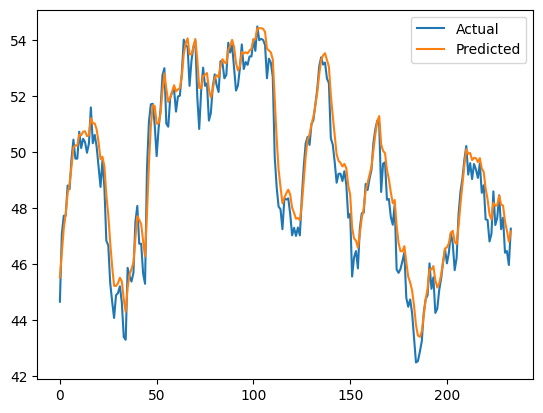

In [ ]:
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred_orig, label='Predicted')
plt.legend()
plt.show()